Plot saved as absorption_length_comparison.png


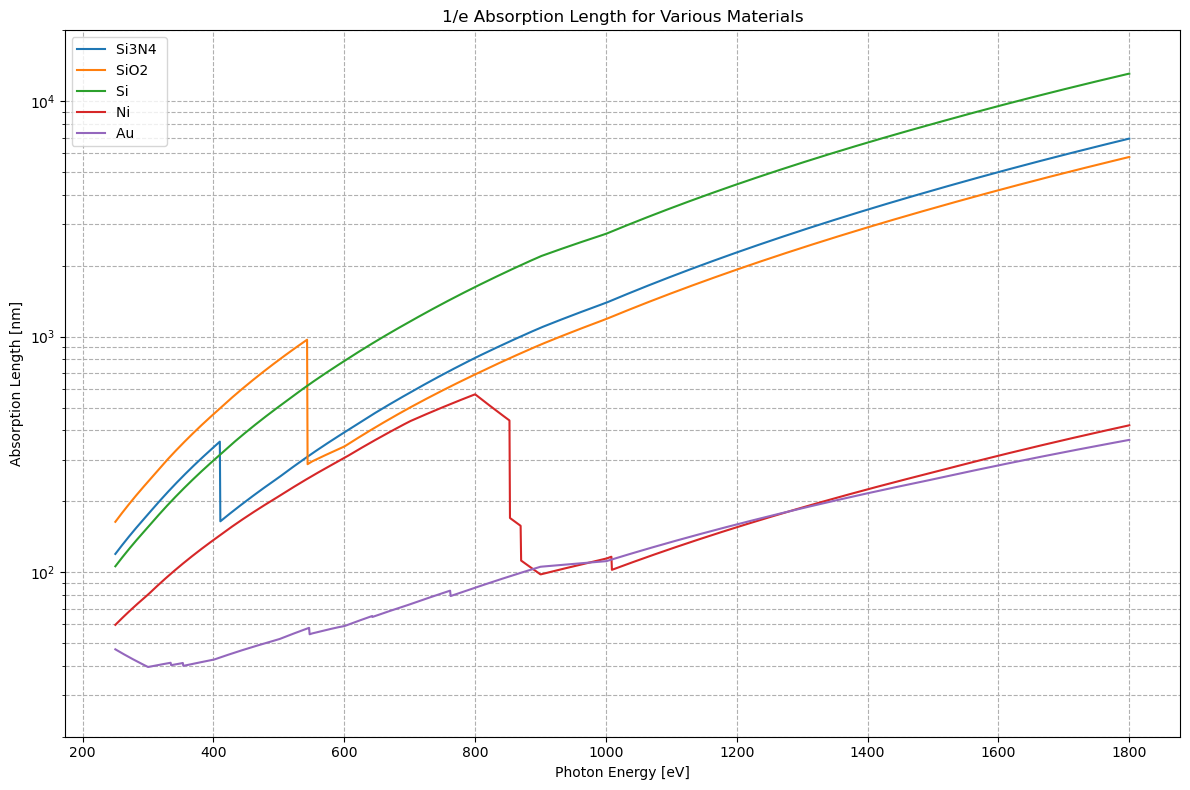

In [9]:
import os
import xraylib
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---

# Define the energy range (250 eV to 1800 eV)
# xraylib functions expect energy in keV
energy_start_kev = 0.25  # 250 eV
energy_end_kev = 1.8     # 1800 eV
num_points = 2000         # Number of points for the plot

# Define the materials to plot
# We'll store them in a dictionary with their type and properties
materials = {
    "Si3N4": {"type": "compound", "density": 3.17},  # Using 3.17 g/cm³
    "SiO2":  {"type": "compound", "density": 2.65},  # Common density for amorphous SiO2
    "Si":    {"type": "element", "Z": 14},
    "Ni":    {"type": "element", "Z": 28},
    "Au":    {"type": "element", "Z": 79},
}

# --- Initialization ---

# Initialize the xraylib library
try:
    xraylib.XRayInit()
except AttributeError:
    # XRayInit is deprecated and auto-initializes in modern versions
    pass

# Get densities for elements from xraylib and add to our dictionary
for material, props in materials.items():
    if props["type"] == "element":
        props["density"] = xraylib.ElementDensity(props["Z"])

# Create an array of energies in keV
energies_kev = np.linspace(energy_start_kev, energy_end_kev, num_points)
# Convert energies from keV to eV for the plot's x-axis
energies_ev = energies_kev * 1000

# --- Plotting Setup ---
plt.figure(figsize=(12, 8))
plt.title("1/e Absorption Length for Various Materials")
plt.xlabel("Photon Energy [eV]")
plt.ylabel("Absorption Length [nm]")
# Use a logarithmic scale for the y-axis, as values span orders of magnitude
plt.yscale('log')
plt.grid(True, which="both", ls="--")

# --- Calculation and Plotting Loop ---

# Loop over each material, calculate its absorption length, and plot it
for material_name, props in materials.items():
    
    mu_mass_cm2_g = np.zeros(num_points)
    density = props["density"]
    
    # Calculate mass absorption coefficient (mu/rho)
    if props["type"] == "compound":
        for i, E_kev in enumerate(energies_kev):
            mu_mass_cm2_g[i] = xraylib.CS_Total_CP(material_name, E_kev)
        # Create a label for the legend
        label = f"{material_name} "
            
    elif props["type"] == "element":
        Z = props["Z"]
        for i, E_kev in enumerate(energies_kev):
            mu_mass_cm2_g[i] = xraylib.CS_Total(Z, E_kev)
        # Create a label for the legend
        label = f"{material_name} "

    # Calculate the linear absorption coefficient (mu = (mu/rho) * rho)
    mu_linear_cm_inv = mu_mass_cm2_g * density

    # Calculate the absorption length (1/e)
    # This is 1 / mu
    with np.errstate(divide='ignore'):
        abs_length_cm = 1.0 / mu_linear_cm_inv

    # Convert absorption length from cm to micrometers (µm)
    # 1 cm = 10,000 µm
    abs_length_nm = abs_length_cm * 1e7

    # Plot the results for this material
    plt.plot(energies_ev, abs_length_nm, label=label)

# --- Finalize Plot ---
plt.ylim([20,2e4])
plt.legend()
plt.tight_layout()

# Save the figure to a file
plt.savefig("absorption_length_comparison.png")
print("Plot saved as absorption_length_comparison.png")

# Show the plot
plt.show()

Plot saved as pi_phase_Gshift_thickness.png


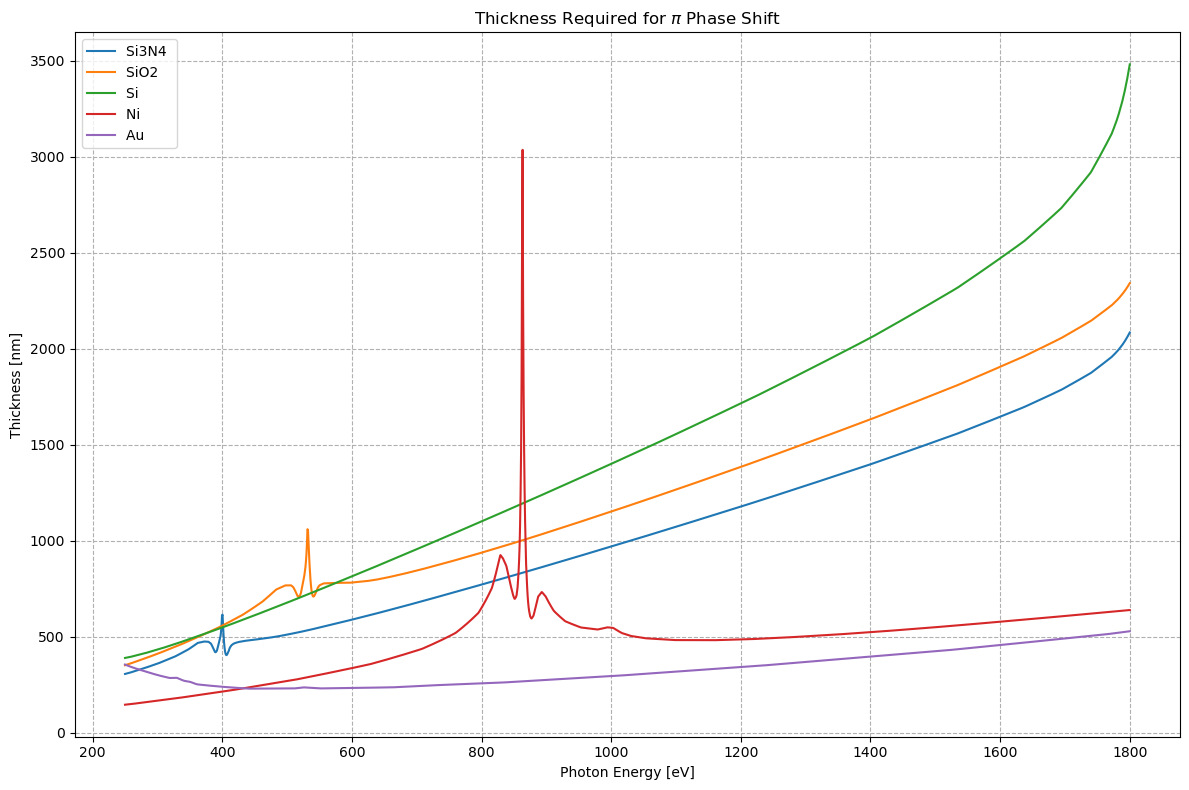

In [19]:
import os
import xraylib
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---

# Define the energy range (250 eV to 1800 eV)
# xraylib functions expect energy in keV
energy_start_kev = 0.25  # 250 eV
energy_end_kev = 1.8     # 1800 eV
num_points = 2000         # Number of points for the plot

# Define the materials to plot
materials = {
    "Si3N4": {"type": "compound", "density": 3.17},  # Using 3.17 g/cm³
    "SiO2":  {"type": "compound", "density": 2.65},  # Amorphous SiO2
    "Si":    {"type": "element", "Z": 14},
    "Ni":    {"type": "element", "Z": 28},
    "Au":    {"type": "element", "Z": 79},
}

# Wavelength-Energy constant
# hc = 12.3984 Angstrom * keV
HC_ANGSTROM_KEV = 12.3984

# --- Initialization ---

# Initialize the xraylib library
try:
    xraylib.XRayInit()
except AttributeError:
    # XRayInit is deprecated and auto-initializes in modern versions
    pass

# Get densities for elements from xraylib
for material, props in materials.items():
    if props["type"] == "element":
        props["density"] = xraylib.ElementDensity(props["Z"])

# Create an array of energies in keV
energies_kev = np.linspace(energy_start_kev, energy_end_kev, num_points)
# Convert energies from keV to eV for the plot's x-axis
energies_ev = energies_kev * 1000

# --- Plotting Setup ---
plt.figure(figsize=(12, 8))
# Use LaTeX for the pi symbol in the title
plt.title(r"Thickness Required for $\pi$ Phase Shift")
plt.xlabel("Photon Energy [eV]")
plt.ylabel("Thickness [nm]")
# Use a logarithmic scale for the y-axis
# plt.yscale('log')
plt.grid(True, which="both", ls="--")

# --- Calculation and Plotting Loop ---

for material_name, props in materials.items():
    
    thickness_nm = np.zeros(num_points)
    density = props["density"]
    
    for i, E_kev in enumerate(energies_kev):
        try:
            # 1. Get delta (decrement of real part of refractive index)
            # xraylib.Refractive_Index_Re returns (1 - delta)
            one_minus_delta = xraylib.Refractive_Index_Re(material_name, E_kev, density)
            delta = 1.0 - one_minus_delta
            
            # 2. Get wavelength in Angstroms
            lambda_angstrom = HC_ANGSTROM_KEV / E_kev
            
            # 3. Calculate thickness for pi-shift (t = lambda / (2 * delta))
            # Result is in Angstroms
            t_angstrom = lambda_angstrom / (2.0 * delta)
            
            # 4. Convert thickness from Angstroms to micrometers
            # 1 micrometer = 10,000 Angstroms
            thickness_nm[i] = t_angstrom * 1e-1
            
        except Exception as e:
            # Handle cases where calculation might fail (e.g., delta is zero)
            thickness_nm[i] = np.nan
            print(f"Error for {material_name} at {E_kev} keV: {e}")

    # Create a label for the legend
    if props["type"] == "compound":
        label = f"{material_name} "
    else:
        label = f"{material_name} "

    # Plot the results for this material
    plt.plot(energies_ev, thickness_nm, label=label)

# --- Finalize Plot ---
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig("pi_phase_shift_thickness.png")

print("Plot saved as pi_phase_Gshift_thickness.png")